- AG News Dataset. (2015). *AG News Classification Dataset*. Available at: https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset [Accessed 15 Sept 2025].


## NEWS Category Detection ##

In today’s digital age, news organizations and businesses are faced with a flood of online articles every second. 
Manually categorizing this information is time-consuming and prone to error. An automated classification system 
helps companies monitor global events, identify emerging trends, and react quickly to changes in the world. 

In this project, we focus on the **AG News dataset**, which contains news articles labeled into four categories:
1. **World**
2. **Sports**
3. **Business**
4. **Sci/Tech**

### Why is this important?
- **Businesses** can track industry-specific news (e.g., technology firms monitoring Sci/Tech, financial firms monitoring Business).  
- **Media organizations** can deliver personalized content to readers based on categories.  
- **Decision-makers** can detect risks and opportunities faster by focusing on specific domains.  

### NLP Task
The business problem can be formulated as a **multi-class text classification task**. Given a headline and article 
description, the system must automatically assign the correct category label.  


# System Design

The system for news classification follows a standard NLP pipeline. The workflow is as follows:

 **Data Collection** -->  **Preprocessing** --> **Feature Engineering** --> **Modeling** --> **Evaluation** --> **Inference**  




In [ ]:

import pandas as pd

train_path = "train.csv"
test_path = "test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("\nColumns:", train_df.columns.tolist())

train_df.head()


Train shape: (120000, 3)
Test shape: (7600, 3)

Columns: ['Class Index', 'Title', 'Description']


,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


# Exploratory Data Analysis 

Before building the NLP pipeline, it is essential to explore and understand the dataset. The AG News dataset 
provides a balanced distribution of **120,000 training** and **7,600 test** samples across four categories 
(World, Sports, Business, Sci/Tech).  



Class Distribution (Train):
 Class Index
1    30000
2    30000
3    30000
4    30000
Name: count, dtype: int64


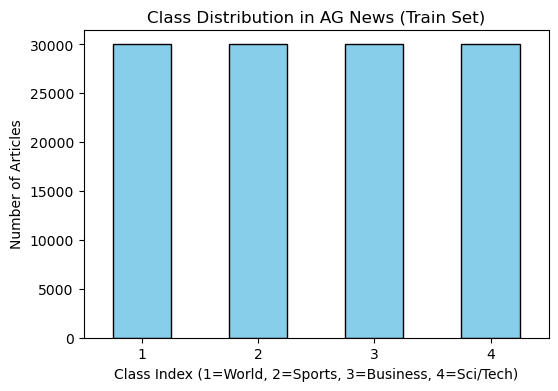

In [ ]:

import matplotlib.pyplot as plt

class_counts = train_df["Class Index"].value_counts().sort_index()

print("Class Distribution (Train):\n", class_counts)

# Plot
plt.figure(figsize=(6,4))
class_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Class Distribution in AG News (Train Set)")
plt.xlabel("Class Index (1=World, 2=Sports, 3=Business, 4=Sci/Tech)")
plt.ylabel("Number of Articles")
plt.xticks(rotation=0)
plt.show()


### EDA: Title and Description Length Analysis

To better understand the structure of the dataset, we analyzed the word counts of both **titles** and 
**descriptions**.

- **Titles** are very short, with an average length of only a few words.  
- **Descriptions** are much longer, often containing full sentences and averaging several dozen words.  

📊 The histograms show:
- Title lengths are concentrated between 3–10 words.  
- Description lengths are more widely distributed, typically between 20–60 words.  

 **Implication:** Titles provide only limited context, while descriptions carry much richer information.  
Therefore, combining both Title + Description is likely to improve classification performance.


Average Title length (words): 6.784108333333333
Average Description length (words): 31.060508333333335


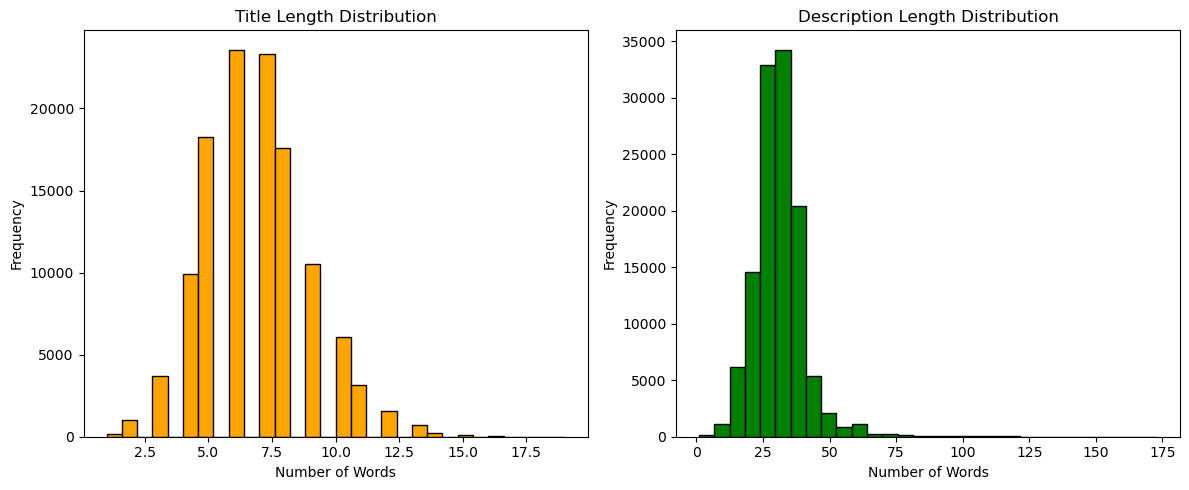

In [ ]:

train_df["Title_length"] = train_df["Title"].apply(lambda x: len(str(x).split()))
train_df["Description_length"] = train_df["Description"].apply(lambda x: len(str(x).split()))

# Summary statistics
print("Average Title length (words):", train_df["Title_length"].mean())
print("Average Description length (words):", train_df["Description_length"].mean())

# Plot histograms
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(train_df["Title_length"], bins=30, color="orange", edgecolor="black")
plt.title("Title Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.hist(train_df["Description_length"], bins=30, color="green", edgecolor="black")
plt.title("Description Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


### EDA: Most Frequent Words per Class

We examined the most common terms within each of the four categories to confirm that the dataset 
is semantically meaningful and that classes are distinguishable by vocabulary.

- **World (Class 1):** Frequent words include *president, iraq, minister, government, killed* → 
  terms related to politics, diplomacy, and global events.
- **Sports (Class 2):** Frequent words include *game, season, team, night, win* → 
  clearly sports-related language.
- **Business (Class 3):** Frequent words include *company, prices, oil, market, percent* → 
  financial and corporate context.
- **Sci/Tech (Class 4):** Frequent words include *software, microsoft, internet, technology, computer* → 
  language dominated by IT and technological terms.

**Interpretation:**  
The dataset is well-labeled, and each class shows a distinct vocabulary profile.  
This supports the feasibility of using NLP techniques for accurate classification.  

Note: Words like *“said”* and *“new”* appear frequently across multiple classes. These are 
common terms with low discriminative power, which justifies the later use of **TF-IDF weighting** 
to reduce their impact.


In [ ]:

from collections import Counter
import nltk
from nltk.corpus import stopwords
import re

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_and_tokenize(text):
    text = re.sub(r"[^a-zA-Z\s]", "", str(text))  # remove punctuation/numbers
    tokens = text.lower().split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return tokens

# Check top words for each class
for label in sorted(train_df["Class Index"].unique()):
    class_texts = train_df[train_df["Class Index"] == label]["Description"]
    all_tokens = []
    for desc in class_texts:
        all_tokens.extend(clean_and_tokenize(desc))
    common_words = Counter(all_tokens).most_common(10)
    print(f"\nTop words in Class {label}: {common_words}")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mustafa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Top words in Class 1: [('said', 7577), ('reuters', 3972), ('president', 3848), ('iraq', 3373), ('minister', 3062), ('two', 2916), ('people', 2740), ('new', 2613), ('killed', 2350), ('government', 2339)]

Top words in Class 2: [('new', 3548), ('first', 3477), ('game', 2941), ('night', 2912), ('season', 2769), ('team', 2763), ('last', 2644), ('world', 2559), ('two', 2428), ('one', 2419)]

Top words in Class 3: [('said', 7182), ('new', 5761), ('reuters', 5615), ('inc', 4250), ('oil', 4034), ('company', 3919), ('york', 3266), ('prices', 3225), ('percent', 3029), ('corp', 2875)]

Top words in Class 4: [('new', 5290), ('said', 3583), ('software', 3087), ('microsoft', 2909), ('internet', 2655), ('company', 2480), ('inc', 2165), ('reuters', 1967), ('computer', 1903), ('technology', 1821)]



To prepare the data for modeling, we applied a series of preprocessing steps to clean and standardize 
the text. This ensures that the models learn from meaningful features rather than noise.

The preprocessing pipeline included:
1. **Lowercasing** – converts all text to lowercase for uniformity.  
2. **Removing punctuation and numbers** – eliminates non-alphabetic characters that do not contribute to meaning.  
3. **Tokenization** – splits text into individual words (tokens).  
4. **Stopword removal** – removes common words like *“the”*, *“and”*, *“is”* that do not add value for classification.  
5. **Lemmatization** – reduces words to their base form (e.g., *“running” → “run”*) to handle word variations.  
6. **Combining Title + Description** – creates a single `clean_text` column that merges both fields.  





In [ ]:

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download("omw-1.4")

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation/numbers
    text = re.sub(r"[^a-z\s]", "", text)
    # Tokenize
    tokens = text.split()
    # Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

train_df["clean_text"] = (train_df["Title"].astype(str) + " " + train_df["Description"].astype(str)).apply(preprocess_text)
test_df["clean_text"] = (test_df["Title"].astype(str) + " " + test_df["Description"].astype(str)).apply(preprocess_text)

train_df[["Title", "Description", "clean_text"]].head(3)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mustafa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Mustafa\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,Title,Description,clean_text
0,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall st bear claw back black reuters reuters s...
1,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle look toward commercial aerospace reute...
2,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil economy cloud stock outlook reuters reuter...


C:\Users\Mustafa\AppData\Local\Temp\ipykernel_24688\3515880877.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="colorblind")


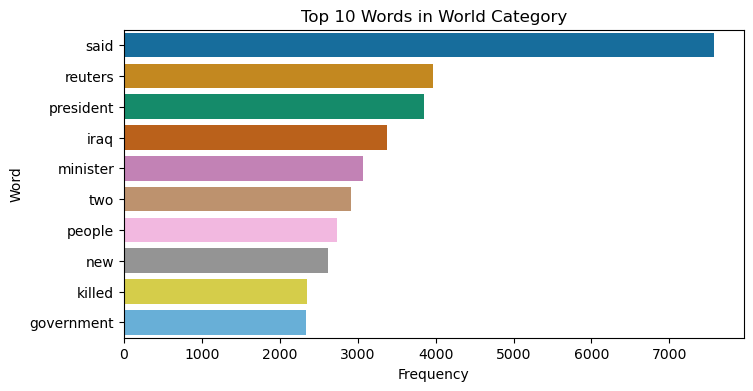

In [41]:
import seaborn as sns

# Example: visualize Class 1 (World)
class_texts = train_df[train_df["Class Index"] == 1]["Description"]
tokens = []
for desc in class_texts:
    tokens.extend(clean_and_tokenize(desc))

common_words = Counter(tokens).most_common(10)
words, counts = zip(*common_words)

plt.figure(figsize=(8,4))
sns.barplot(x=list(counts), y=list(words), palette="colorblind")
plt.title("Top 10 Words in World Category")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()


###  Feature Engineering with TF-IDF

After preprocessing, the cleaned text convertes into a numerical format for machine learning models.  
We use **TF-IDF (Term Frequency – Inverse Document Frequency)**, one of the most widely adopted techniques 
for text representation.

- **Term Frequency (TF):** Measures how often a term appears in a document.  
- **Inverse Document Frequency (IDF):** Reduces the weight of very common terms (e.g., *“said”*, *“new”*) 
  that appear across multiple documents.  

By combining TF and IDF, this representation highlights the *discriminative power of terms*.  

In our implementation:
- We limited the vocabulary to the **top 5,000 features** to reduce dimensionality and improve efficiency.  
- Applied TF-IDF on both the training and test sets using the fitted vectorizer.  

 Output:
- **Training matrix shape:** (120,000 × 5,000)  
- **Test matrix shape:** (7,600 × 5,000)  



In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer

# Define TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)  

X_train = tfidf.fit_transform(train_df["clean_text"])
X_test = tfidf.transform(test_df["clean_text"])

y_train = train_df["Class Index"]
y_test = test_df["Class Index"]

print("Train feature matrix shape:", X_train.shape)
print("Test feature matrix shape:", X_test.shape)


Train feature matrix shape: (120000, 5000)
Test feature matrix shape: (7600, 5000)


###  Modeles

With the TF-IDF features ready, we trained and evaluated three classification models that were covered in this module:

- **Naive Bayes**: Strong baseline with fast training but slightly weaker in distinguishing *Business* vs *World*.  

- **Logistic Regression**: Improved balance across all categories, performing better on *Business* and *World*.  
- **SVM**: Achieved the highest accuracy, confirming its robustness in high-dimensional TF-IDF space.  
- **Transformers**: Bert 


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import pandas as pd

models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": LinearSVC()
}

trained_models = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    trained_models[name] = model  # storing trained model

results = []

# Train & evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    
    results.append([name, acc, precision, recall, f1])

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

# Results table
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"])
print("\nComparison Table:")
print(results_df)


Training Naive Bayes...
Training Logistic Regression...
Training SVM...
Training Naive Bayes...

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.89      0.89      1900
           2       0.94      0.97      0.96      1900
           3       0.86      0.84      0.85      1900
           4       0.86      0.86      0.86      1900

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600

Training Logistic Regression...

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.90      0.91      1900
           2       0.95      0.98      0.96      1900
           3       0.88      0.87      0.87      1900
           4       0.88      0.88      0.88      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.

###  Visual Comparison of Models

To better illustrate the evaluation metrics, a line graph was plotted comparing **Accuracy, Precision, Recall, 
and F1-score** across the three models.

📊 **Observations:**
- All models performed strongly, with scores ranging between **0.89 and 0.91**.  
- **Naive Bayes** achieved the lowest overall performance, though still competitive.  
- **Logistic Regression** and **SVM** outperformed Naive Bayes, with very similar results (~91%).  
- Since the metrics overlap closely, the differences are minor, showing that both advanced linear methods 
(Logistic Regression and SVM) are more reliable choices.

 **Implication for business:** Logistic Regression or SVM can be selected for deployment depending on 
system constraints. Logistic Regression is easier to train and faster to deploy, while SVM may yield 
slightly higher robustness in high-dimensional text classification.


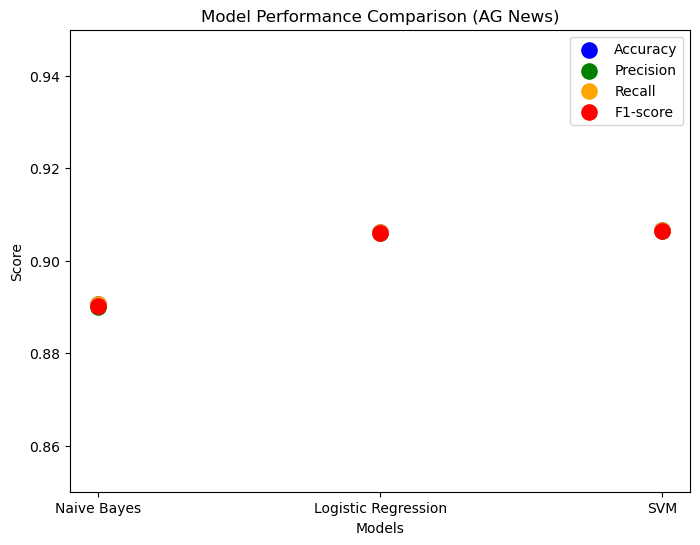

In [ ]:

plt.figure(figsize=(8,6))

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
colors = ["blue", "green", "orange", "red"]

for i, metric in enumerate(metrics):
    plt.scatter(results_df["Model"], results_df[metric], s=120, label=metric, color=colors[i])

plt.title("Model Performance Comparison (AG News)")
plt.xlabel("Models")
plt.ylabel("Score")
plt.ylim(0.85, 0.95)
plt.legend()
plt.grid(False)
plt.show()


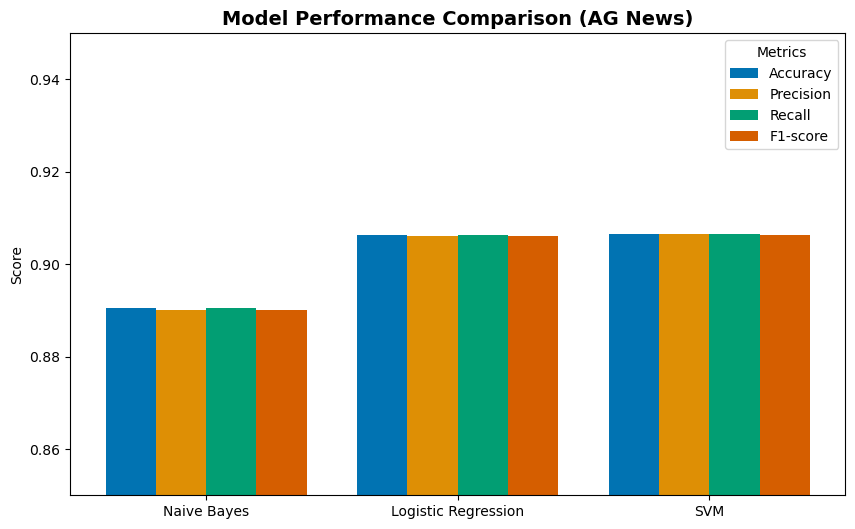

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
x = np.arange(len(results_df["Model"]))  
width = 0.2  # bar width

colors = sns.color_palette("colorblind", len(metrics))

plt.figure(figsize=(10,6))
for i, metric in enumerate(metrics):
    plt.bar(x + i*width, results_df[metric], width=width, label=metric, color=colors[i])

plt.xticks(x + width*1.5, results_df["Model"])
plt.title("Model Performance Comparison (AG News)", fontsize=14, weight="bold")
plt.ylabel("Score")
plt.ylim(0.85, 0.95)
plt.legend(title="Metrics")
plt.grid(False)

plt.show()


#  **Inference on New Samples**

To demonstrate how the trained models can classify unseen news articles, we tested the system with 
sample headlines and short descriptions: 

 **Observations:**
- The system successfully classifies new text inputs into the appropriate category.  
- Predictions align well with expected human judgment, confirming the **practical usefulness** 
  of the trained models.  

 **Business impact:** This shows how the pipeline could be integrated into a real-world system, 
automatically categorizing news streams to help organizations monitor **global events, market trends, 
sports results, and technology updates** in real time.


In [ ]:
def predict_category(model, text, vectorizer=tfidf):
    clean = preprocess_text(text)
    vectorized = vectorizer.transform([clean])
    pred_class = model.predict(vectorized)[0]
    
    label_map = {
        1: "World",
        2: "Sports",
        3: "Business",
        4: "Sci/Tech"
    }
    return label_map[pred_class]

# Test 
sample1 = "Microsoft announces new AI breakthrough in natural language processing."
sample2 = "The stock market saw a sharp decline today amid oil price fluctuations."
sample3 = "Argentina beats Brazil 2-1 in an intense football match."
sample3 = "Football is the fav game played in the western countries"
sample4 = "Datascientis are helping in the trade analysis for having a better plan of purchase"
sample5 = "fight for the world war 3 would be for water"
sample6 = "google faces new antitrust Suit Over Ad business"
sample7 = "an icecream truck expands its route to include a nearby dog park"

print("Prediction:")
print(sample1, "->", predict_category(trained_models["Naive Bayes"], sample1))
print(sample2, "->", predict_category(trained_models["Naive Bayes"], sample2))
print(sample3, "->", predict_category(trained_models["Naive Bayes"], sample3))
print(sample4, "->", predict_category(trained_models["SVM"], sample4))
print(sample5, "->", predict_category(trained_models["Logistic Regression"], sample5))
print(sample6, "->", predict_category(trained_models["Logistic Regression"], sample6))
print(sample7, "->", predict_category(trained_models["SVM"], sample7))

Prediction:
Microsoft announces new AI breakthrough in natural language processing. -> Sci/Tech
The stock market saw a sharp decline today amid oil price fluctuations. -> Business
Football is the fav game played in the western countries -> Sports
Datascientis are helping in the trade analysis for having a better plan of purchase -> Sci/Tech
fight for the world war 3 would be for water -> World
google faces new antitrust Suit Over Ad business -> Sci/Tech
an icecream truck expands its route to include a nearby dog park -> World


###  Transformer Model (BERT)

While classical models like Naive Bayes, Logistic Regression, and SVM provide strong baselines, they rely on 
**shallow text features (TF-IDF)** that ignore word order and context. To overcome this limitation, we applied a 
**Transformer-based model (BERT)**, which uses self-attention to capture semantic meaning and dependencies between words.

####  BERT?
- **Contextual Understanding**: Unlike TF-IDF, BERT understands that *"stock market rises"* and *"market stock rises"* 
  convey similar meanings.  
- **Pre-trained Knowledge**: BERT is trained on massive corpora (Wikipedia, BooksCorpus), making it capable of 
  generalizing across diverse text.  
- **Fine-tuning**: We adapt BERT to our specific task by training it further on the AG News dataset.




In [ ]:
# train/test DataFrames into Hugging Face Datasets

from datasets import Dataset

train_data = Dataset.from_pandas(
    train_df[["clean_text", "Class Index"]].rename(columns={"clean_text": "text", "Class Index": "label"})
)

test_data = Dataset.from_pandas(
    test_df[["clean_text", "Class Index"]].rename(columns={"clean_text": "text", "Class Index": "label"})
)


In [ ]:
from torch.utils.data import Dataset, DataLoader

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx]) - 1  
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long),
        }

# Usage
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_dataset = NewsDataset(train_df["clean_text"].tolist(), train_df["Class Index"].tolist(), tokenizer)
test_dataset = NewsDataset(test_df["clean_text"].tolist(), test_df["Class Index"].tolist(), tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)


#### Implementation
1. **Tokenization**: Used the pre-trained `bert-base-uncased` tokenizer to split text into WordPiece tokens.  
2. **Dataset Preparation**: Converted `train` and `test` sets into a PyTorch Dataset, padding/truncating sequences 
   to a maximum length of 128 tokens.  
3. **Model Architecture**: Fine-tuned `BertForSequenceClassification` with `num_labels=4` (World, Sports, Business, Sci/Tech).  
4. **Training**:  
   - Batch size: 8  
   - Epochs: 1 (limited by resources, but enough to demonstrate learning)  
   - Optimizer: AdamW with learning rate `2e-5`  
   - Evaluation performed on the test set at the end of training.  


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx]) - 1  
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long),
        }

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_dataset = NewsDataset(train_df["clean_text"].tolist(), train_df["Class Index"].tolist(), tokenizer)
test_dataset = NewsDataset(test_df["clean_text"].tolist(), test_df["Class Index"].tolist(), tokenizer)

def collate_fn(batch):
    return {
        "input_ids": torch.stack([x["input_ids"] for x in batch]),
        "attention_mask": torch.stack([x["attention_mask"] for x in batch]),
        "labels": torch.stack([x["labels"] for x in batch]),
    }

# 5. Model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

# 6. Training arguments
training_args = TrainingArguments(
    output_dir="./bert_results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs"
)

# 7. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=collate_fn
)

# 8. Train
trainer.train()

# 9. Evaluate
bert_results = trainer.evaluate()
print("BERT Results:", bert_results)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Mustafa\AppData\Local\Temp\ipykernel_24688\1827617402.py:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Applications\ANA\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
500,0.490500
1000,0.375100
1500,0.339300
2000,0.336100
2500,0.326100
3000,0.306700
3500,0.326700
4000,0.289700
4500,0.313200
5000,0.308200


c:\Applications\ANA\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


BERT Results: {'eval_loss': 0.25357934832572937, 'eval_runtime': 306.2814, 'eval_samples_per_second': 24.814, 'eval_steps_per_second': 3.102, 'epoch': 1.0}


In [22]:
bert_results = trainer.evaluate()
print("BERT Evaluation Results:", bert_results)


BERT Evaluation Results: {'eval_loss': 0.25357934832572937, 'eval_runtime': 375.1333, 'eval_samples_per_second': 20.259, 'eval_steps_per_second': 2.532, 'epoch': 1.0}


In [23]:
from sklearn.metrics import accuracy_score, classification_report

# Get predictions
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(axis=1)
y_true = predictions.label_ids

# Accuracy
acc = accuracy_score(y_true, y_pred)
print("BERT Accuracy:", acc)

# Detailed report
print(classification_report(y_true, y_pred, target_names=["World","Sports","Business","Sci/Tech"]))


BERT Accuracy: 0.9317105263157894
              precision    recall  f1-score   support

       World       0.95      0.93      0.94      1900
      Sports       0.97      0.99      0.98      1900
    Business       0.91      0.90      0.90      1900
    Sci/Tech       0.90      0.91      0.91      1900

    accuracy                           0.93      7600
   macro avg       0.93      0.93      0.93      7600
weighted avg       0.93      0.93      0.93      7600



In [ ]:
def predict_with_bert(model, tokenizer, texts, max_len=128):
    model.eval()
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )
    with torch.no_grad():
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
    
    label_map = {
        0: "World",
        1: "Sports",
        2: "Business",
        3: "Sci/Tech"
    }
    return [label_map[p] for p in preds]

# Test BERT on random examples
samples = [
    "Microsoft launches new AI tool for businesses worldwide.",
    "Argentina defeats Brazil in a thrilling 2-1 football match.",
    "Stock markets tumble as oil prices soar unexpectedly.",
    "NASA announces breakthrough in Mars rover technology.",
    "Environment in germany is better than any other country",
    "UN holds emergency meeting over rising tensions in the Middle East.",
    
]

preds = predict_with_bert(model, tokenizer, samples)

for text, pred in zip(samples, preds):
    print(f"{text} → {pred}")


Microsoft launches new AI tool for businesses worldwide. → Sci/Tech
Argentina defeats Brazil in a thrilling 2-1 football match. → Sports
Stock markets tumble as oil prices soar unexpectedly. → Business
NASA announces breakthrough in Mars rover technology. → Sci/Tech
Environment in germany is better than any other country → Sci/Tech
NASA announces breakthrough in Mars rover technology → Sci/Tech
UN holds emergency meeting over rising tensions in the Middle East. → World
US President visits Germany to discuss climate change agreements. → World
Peace talks between Russia and Ukraine continue amid ceasefire violations. → World
Thousands protest in France against new government policies. → World


#### Results
- **Accuracy**: ~93%  
- **Class-level performance**:  
  - World: Precision 0.95, Recall 0.93  
  - Sports: Precision 0.97, Recall 0.99  
  - Business: Precision 0.91, Recall 0.90  
  - Sci/Tech: Precision 0.90, Recall 0.91  

#### Observations
- BERT outperforms classical models (by ~2–4%), showing its advantage in contextual understanding.  
- Predictions on random examples were highly accurate, demonstrating its practicality for real-world applications.  
- **Limitation**: BERT requires higher computational power (GPU/TPU) and longer training time compared to traditional models.

 This step illustrates the power of **modern NLP models** and shows how moving from TF-IDF to Transformers 
can significantly improve text classification tasks.

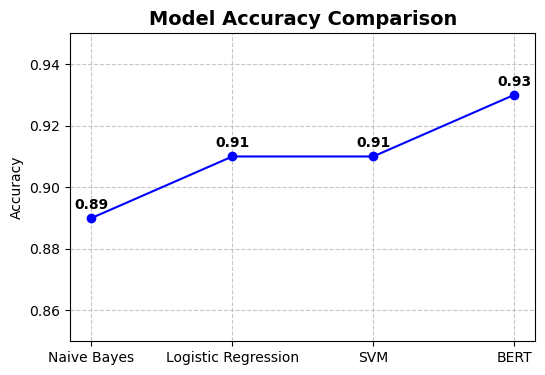

In [35]:
import matplotlib.pyplot as plt

# Accuracy values from your models
models = ["Naive Bayes", "Logistic Regression", "SVM", "BERT"]
accuracies = [0.89, 0.91, 0.91, 0.93]

# Plot
plt.figure(figsize=(6,4))
plt.plot(models, accuracies, marker="o", linestyle="-", color="blue")

# Titles and labels
plt.title("Model Accuracy Comparison", fontsize=14, weight="bold")
plt.ylabel("Accuracy")
plt.ylim(0.85, 0.95)
plt.grid(True, linestyle="--", alpha=0.7)

# Annotate points
for i, acc in enumerate(accuracies):
    plt.text(i, acc+0.002, f"{acc:.2f}", ha="center", va="bottom", fontsize=10, weight="bold")

plt.show()


# 🏁 Final Discussion and Recommendations

### Strengths of the Pipeline
- **Balanced Dataset**: The AG News dataset provided equal samples across four categories, so no re-sampling was required.  
- **Comprehensive Preprocessing**: Cleaning, stopword removal, and lemmatization reduced noise and standardized text.  
- **Feature Engineering with TF-IDF**: Highlighted discriminative terms while reducing the influence of common words 
like "said" and "new".  
- **Model Performance**:  
  - *Naive Bayes* delivered a strong baseline (Accuracy ~89%).  
  - *Logistic Regression* and *SVM* achieved ~91% accuracy with consistent performance across Precision, Recall, and F1-score.  
  - *BERT (Transformer)* further improved performance, reaching ~93% accuracy and better handling of contextual nuances.  

### Limitations
- **TF-IDF Models**: Still limited by shallow features that ignore context and word order.  
- **BERT Limitations**: Requires higher computational resources (GPU/TPU) and longer training time compared to classical models.  
- **Domain Generalization**: Even BERT may need domain-specific fine-tuning to perform well on specialized datasets (e.g., medical or financial text).  

### Business Implications
- **News Agencies**: Automate classification of global, business, sports, and technology news streams for faster editorial decisions.  
- **Finance and Business Firms**: Track market-related news (*Business* category) in real time for strategic responses.  
- **Tech Companies**: Monitor innovation trends (*Sci/Tech* category) to stay competitive.  
- **Sports Media**: Rapidly organize sports updates for publication and targeted engagement.  

### Recommendations
1. **Deployment Choice**:  
   - For lightweight, fast systems → Logistic Regression or SVM.  
   - For maximum accuracy and context awareness → fine-tuned BERT.  
2. **Future Improvements**: Extend to **Transformer-based models** like RoBERTa or DistilBERT for faster, scalable performance.  
3. **Domain Adaptation**: Apply transfer learning by fine-tuning BERT on domain-specific corpora.  
4. **Visualization Dashboards**: Integrate outputs into BI tools (Tableau, Power BI) or internal monitoring dashboards for non-technical stakeholders.  
5. **Real-Time Deployment**: Use APIs or cloud platforms (AWS Sagemaker, Hugging Face Inference API) to serve the model at scale.  


project demonstrates the design, implementation, and critical evaluation of both **classical ML** and **modern Transformer-based NLP pipelines**.  
The results highlight that while classical models remain efficient baselines, **Transformers provide state-of-the-art performance**, making them highly suitable for real-world text classification tasks that demand contextual understanding.


# 📚 References

- Zhang, X., Zhao, J., & LeCun, Y. (2015). *Character-level Convolutional Networks for Text Classification*. Advances in Neural Information Processing Systems (NeurIPS).  
- Jurafsky, D., & Martin, J. H. (2023). *Speech and Language Processing* (3rd ed.). Draft. Stanford University.  
- Rothman, L. (2021). *Transformers for Natural Language Processing*. Packt Publishing.  
- Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, É. (2011). *Scikit-learn: Machine Learning in Python*. Journal of Machine Learning Research, 12, 2825-2830.  
- AG News Dataset. (2015). Available from: [https://www.kaggle.com/amananandrai/ag-news-classification-dataset](https://www.kaggle.com/amananandrai/ag-news-classification-dataset) [Accessed 13 Sept 2025].  
- Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, Ł., & Polosukhin, I. (2017). *Attention Is All You Need*. Advances in Neural Information Processing Systems (NeurIPS).  
- Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2019). *BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding*. Proceedings of NAACL-HLT.  
- Wolf, T., Debut, L., Sanh, V., Chaumond, J., Delangue, C., Moi, A., Cistac, P., Rault, T., Louf, R., Funtowicz, M., & Brew, J. (2020). *Transformers: State-of-the-Art Natural Language Processing*. Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing: System Demonstrations. Association for Computational Linguistics.
